## Karsten Errando Winoto
## 21102254
## IF 09 SC 1

# Import libray

In [33]:
import numpy as np 
import cv2 as cv
import os 
import torch 
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd

from glob import glob
from torch.utils.data import Dataset, DataLoader

# Dataset

In [15]:
a = 'D:/SEKOLAH/KULIAH/SEMESTER 6/PENGENALAN POLA/21102254_Karsten Errando Winoto_IF 09 SC 1_Pengenalan Pola 1/DS_GEKCO/ALBINO'
b = 'D:/SEKOLAH/KULIAH/SEMESTER 6/PENGENALAN POLA/21102254_Karsten Errando Winoto_IF 09 SC 1_Pengenalan Pola 1/DS_GEKCO/BOLDSTRIPE'
ab  = 'D:/SEKOLAH/KULIAH/SEMESTER 6/PENGENALAN POLA/21102254_Karsten Errando Winoto_IF 09 SC 1_Pengenalan Pola 1/DS_GEKCO/BOLDSTIPE_ALBINO'

In [12]:
def ambil_data(folder):
    gecko = []
    dir_list = os.listdir(folder)
    for i in dir_list :
      data = cv.imread(folder + '/' + i)
      data = cv.resize(data,(300,300))
      data = data/255
      gecko.append(data)
    return gecko

In [16]:
data_a = np.array(ambil_data(a))
data_b = np.array(ambil_data(b))
data_ab = np.array(ambil_data(ab))

In [17]:
class TrajectoriesData(torch.utils.data.Dataset):
    def __init__(self, data):
        to1hot = np.eye(3)
        self.dataset = []
        for d, label in data:
            #print(d, label)
            self.dataset += [
                (im, to1hot[label]) for im in d
            ]
        #print(len(self.dataset))
    def __len__(self):
            return len(self.dataset)

    def __getitem__(self, index:int) -> (np.ndarray, int):
            vec, label = self.dataset[index]
            return torch.tensor(vec, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

In [18]:
train_data = torch.utils.data.DataLoader(TrajectoriesData([
    (data_a[:16],0),
    (data_b[:16],1),
    (data_ab[:16],2)
    ]),batch_size=8,shuffle = True)
test_data = torch.utils.data.DataLoader(TrajectoriesData([
    (data_a[16:],0),
    (data_b[16:],1),
    (data_ab[16:],2)]),batch_size=8,shuffle = True)

# Model Transfomer

In [19]:
class CNNFormer(nn.Module):
  def __init__(self, feature_dim, dff=1024, num_head=1,num_layer=1, n_class=3, dropout=0.1, device='cpu'):
    super(CNNFormer, self).__init__()
    self.layer = num_layer
    self.conv = nn.Sequential(
      nn.Conv2d(feature_dim, 20, 2),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),
      nn.Conv2d(20, 20, 5),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),
      nn.Conv2d(20, 20, 3),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),
      nn.Conv2d(20, 20, 3),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),
      nn.Dropout(p=dropout),
    )

    # Hitung hidden_dim berdasarkan jumlah filter terbanyak
    self.hidden_dim = 20
    self.MHA = nn.MultiheadAttention(embed_dim=self.hidden_dim,num_heads=num_head, bias=False, dropout=dropout).to(device)
    self.feed_forward = nn.Sequential(
      nn.Linear(self.hidden_dim, dff),
      nn.ReLU(),
      nn.Linear(dff, self.hidden_dim)
    )
    self.norm = nn.LayerNorm(self.hidden_dim)
    # Sesuaikan dimensi lapisan linear
    self.lin_out = nn.Linear(self.hidden_dim * 256, n_class) #Ubah input size
  def forward(self, x):
    # Layer convolution
    x = self.conv(x)
    # Ubah dimensi tensor untuk sesuai dengan input multi-head  attention
    batch_size, channels, height, width = x.size()
    x = x.view(batch_size, channels, -1).permute(0, 2, 1)
    # Layer transformer encoder
    for i in range(self.layer):
      y, _ = self.MHA(x, x, x)
      x = x + self.norm(y)
      y = self.feed_forward(x)
      x = x + self.norm(y)
      # Kembalikan dimensi ke format semula
      x = x.permute(0, 2, 1).view(batch_size, channels, height,
      width)
      # Ubah dimensi tensor untuk sesuai dengan lapisan linear
      x = x.reshape(batch_size, -1)
      # Layer linear output
      x = self.lin_out(x)
    return x

# Training

In [20]:
model = CNNFormer(feature_dim = 3 )
model.to(device='cpu')
optimizer = optim.Adam(model.parameters(), lr = 0.01)
criterion  = nn.CrossEntropyLoss()
EPOCH = 100
device = 'cpu'
loss_all = []
accuracy_all =[]
total_correct = 0
total_samples = 0
for epoch in range(EPOCH):
    loss_total = 0
    for batch, (src, trg) in enumerate(train_data):
        #print(src.shape)
        #print(trg.shape)
        src = src.permute(0,3,1,2)
        pred = model(src).to(device)
        loss = criterion(pred, trg.to(device))
        loss_total+=loss.item()
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_correct += (torch.argmax(pred, dim=1) == torch.argmax(trg, dim=1)).sum().item()
        total_samples += trg.size(0)
    loss_batch = loss_total / len(train_data)
    loss_all.append(loss_batch)
    accuracy = total_correct / total_samples
    accuracy_all.append(accuracy)
    print(f'Epoch {epoch+1}/{EPOCH}, Loss: {loss_batch:.4f}, Accuracy: {accuracy:.4f}')
    

Epoch 1/100, Loss: 57.3554, Accuracy: 0.2708
Epoch 2/100, Loss: 12.5446, Accuracy: 0.3646
Epoch 3/100, Loss: 13.2950, Accuracy: 0.3403
Epoch 4/100, Loss: 11.2541, Accuracy: 0.3385
Epoch 5/100, Loss: 4.1744, Accuracy: 0.3417
Epoch 6/100, Loss: 7.7634, Accuracy: 0.3368
Epoch 7/100, Loss: 5.8040, Accuracy: 0.3363
Epoch 8/100, Loss: 3.2551, Accuracy: 0.3359
Epoch 9/100, Loss: 4.8417, Accuracy: 0.3310
Epoch 10/100, Loss: 2.4853, Accuracy: 0.3417
Epoch 11/100, Loss: 1.5615, Accuracy: 0.3504
Epoch 12/100, Loss: 0.9067, Accuracy: 0.3698
Epoch 13/100, Loss: 1.0139, Accuracy: 0.3830
Epoch 14/100, Loss: 0.7550, Accuracy: 0.3943
Epoch 15/100, Loss: 0.8092, Accuracy: 0.4069
Epoch 16/100, Loss: 0.9315, Accuracy: 0.4180
Epoch 17/100, Loss: 0.9598, Accuracy: 0.4301
Epoch 18/100, Loss: 0.8158, Accuracy: 0.4444
Epoch 19/100, Loss: 0.6179, Accuracy: 0.4561
Epoch 20/100, Loss: 0.5699, Accuracy: 0.4656
Epoch 21/100, Loss: 0.5354, Accuracy: 0.4772
Epoch 22/100, Loss: 0.6061, Accuracy: 0.4839
Epoch 23/100, L

# Evaluasi

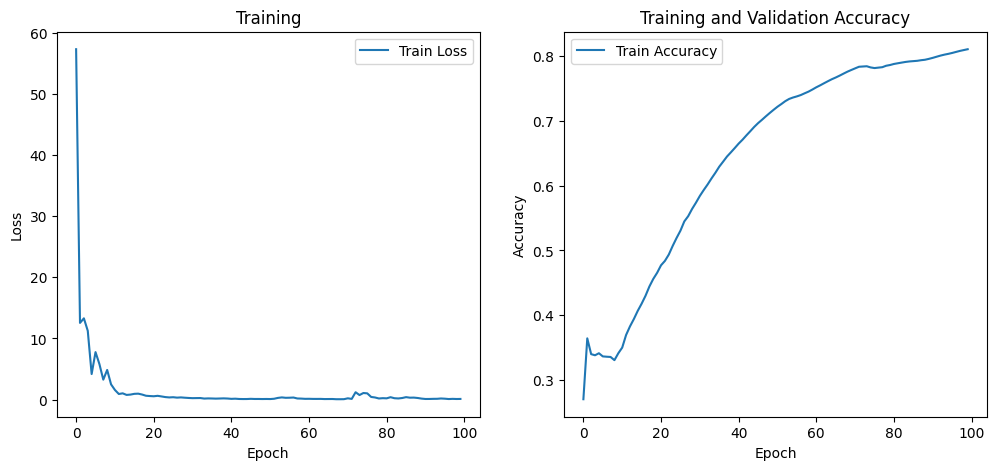

In [23]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCH), loss_all, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCH), accuracy_all, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [30]:
model.eval() #mode evaluasi
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for batch, (src, trg) in enumerate(test_data):
        src = src.permute(0, 3, 1, 2).to(device)
        trg = trg.to(device)

        # Forward
        outputs = model(src)

        # Ambil prediksi dan label asli (dalam bentuk index kelas)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        labels = torch.argmax(trg, dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)
print("Classification Report:")
print(classification_report(all_labels, all_preds))

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.25      0.29         4
           1       0.43      0.75      0.55         4
           2       0.50      0.25      0.33         4

    accuracy                           0.42        12
   macro avg       0.42      0.42      0.39        12
weighted avg       0.42      0.42      0.39        12



In [34]:
report = classification_report(all_labels,all_preds, output_dict=True)
df_report = pd.DataFrame(report).transpose()

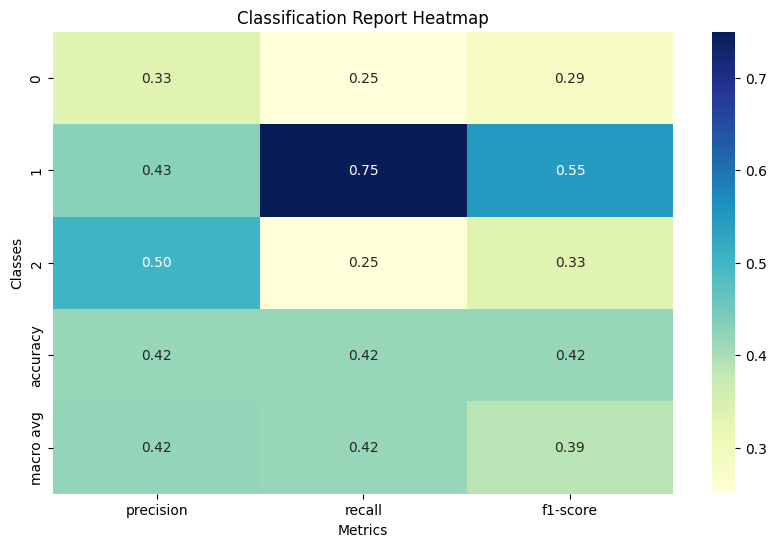

In [35]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Classification Report Heatmap")
plt.ylabel("Classes")
plt.xlabel("Metrics")
plt.show()